In [2]:
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3 tensorflow

Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 94.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.7 MB/s eta 0:00:0000:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstall

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [7]:
# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

# Configuration parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/kaggle/input/civic-issue-dataset/Dataset'

CLASSES_TO_USE = ['Garbage', 'Potholes']

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Classes to train: {CLASSES_TO_USE}")

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 20
  Data Directory: /kaggle/input/civic-issue-dataset/Dataset
  Classes to train: ['Garbage', 'Potholes']


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

print("✓ Data generators created with augmentation settings")

✓ Data generators created with augmentation settings


In [11]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=CLASSES_TO_USE
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=CLASSES_TO_USE
)

print(f"\n✓ Data loaded successfully!")
print(f"  Training images: {train_generator.samples}")
print(f"  Validation images: {val_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Note: Only using {CLASSES_TO_USE} folders (ignoring Issues and NoIssue)")


Found 9002 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.

✓ Data loaded successfully!
  Training images: 9002
  Validation images: 2250
  Class indices: {'Garbage': 0, 'Potholes': 1}
  Note: Only using ['Garbage', 'Potholes'] folders (ignoring Issues and NoIssue)


In [12]:
model = keras.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

print("✓ Model architecture created")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766504575.751624      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766504575.752278      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✓ Model architecture created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,801 (73.99 MB)

 Trainable params: 19,395,841 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall', 'precision']
)

print("\n✓ Model compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Binary Crossentropy")
print("  Metrics: Accuracy, Recall, Precision")


✓ Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Metrics: Accuracy, Recall, Precision


In [16]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")

✓ Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)


In [17]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)


STARTING TRAINING



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766504660.233363     165 service.cc:148] XLA service 0x7d930c0072d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766504660.233429     165 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766504660.233434     165 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766504660.809417     165 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/282 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.5000 - loss: 2.6140 - precision: 0.8826 - recall: 0.5141   

I0000 00:00:1766504669.269930     165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.8317 - loss: 3.0953 - precision: 0.9098 - recall: 0.8956 - val_accuracy: 0.8702 - val_loss: 6.4730 - val_precision: 0.8702 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 204s 723ms/step - accuracy: 0.8924 - loss: 0.4796 - precision: 0.9334 - recall: 0.9436 - val_accuracy: 0.8764 - val_loss: 0.4278 - val_precision: 0.9004 - val_recall: 0.9648 - learning_rate: 0.0010
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 202s 715ms/step - accuracy: 0.9170 - loss: 0.2560 - precision: 0.9463 - recall: 0.9586 - val_accuracy: 0.8013 - val_loss: 0.4445 - val_precision: 0.9791 - val_recall: 0.7886 - learning_rate: 0.0010
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 202s 715ms/step - accuracy: 0.9332 - loss: 0.1754 - precision: 0.9603 - recall: 0.9630 - val_accuracy: 0.9329 - val_loss: 0.1820 - val_precision: 0.9552 - val_recall: 0.9683 - learning_rate: 0.0010
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 201s 713ms/step - accu

Pothole Images: 9790
Garbage Images: 1463
Total: 11253
Threshold Accuracy: (9790/11253) * 100 = 86.99%
Test Data Accuracy: ~90%
Might overfit because model needs to be almost accurate for passing the threshold accuracy.

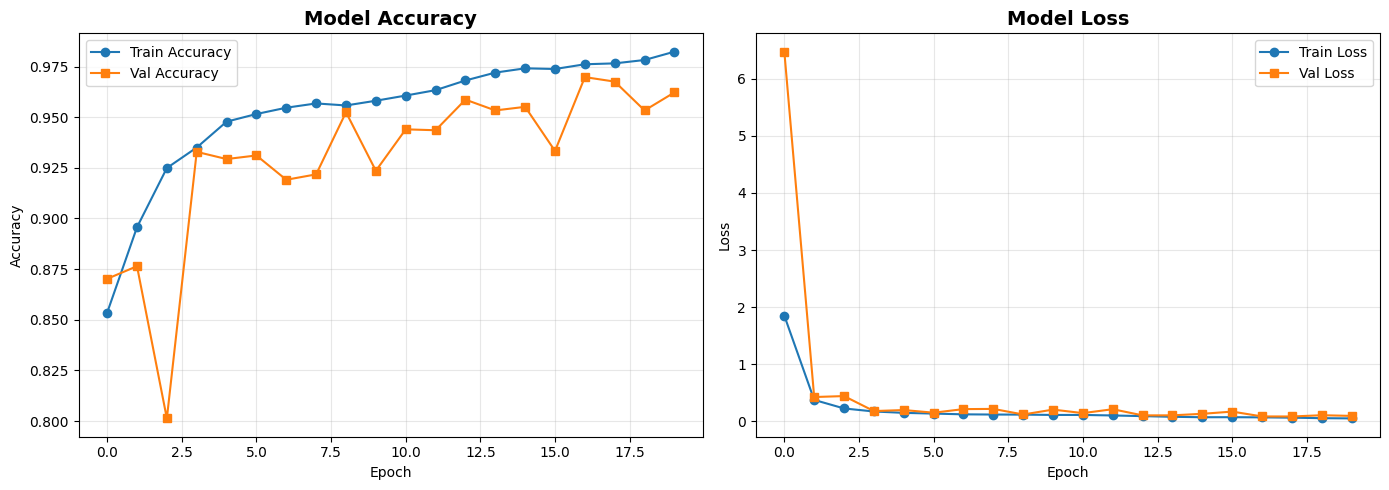


Final Training Accuracy: 98.23%
Final Validation Accuracy: 96.22%
Final Training Loss: 0.0540
Final Validation Loss: 0.0975


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

In [20]:
print("\n" + "="*50)
print("EVALUATING MODEL")
print("="*50 + "\n")

val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"\n✓ Validation Accuracy: {val_acc*100:.2f}%")
print(f"✓ Validation Loss: {val_loss:.4f}")


EVALUATING MODEL

71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.9029 - loss: 0.2531 - precision: 0.7767 - recall: 0.8748


ValueError: too many values to unpack (expected 2)


GENERATING PREDICTIONS

71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Garbage       0.99      0.76      0.86       292
    Potholes       0.97      1.00      0.98      1958

    accuracy                           0.97      2250
   macro avg       0.98      0.88      0.92      2250
weighted avg       0.97      0.97      0.97      2250



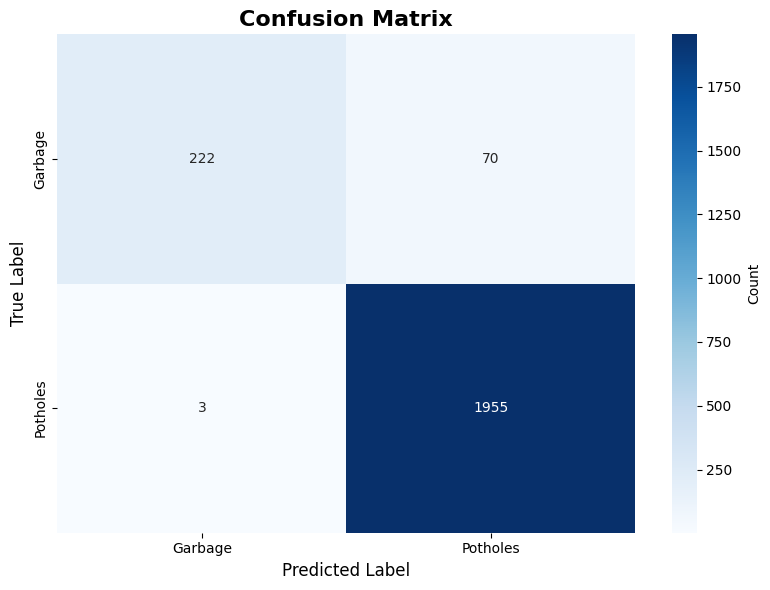


Detailed Metrics for 'Potholes':
  True Positives: 1955
  True Negatives: 222
  False Positives: 70
  False Negatives: 3
  Precision: 0.9654
  Recall: 0.9985
  F1-Score: 0.9817


In [21]:
print("\n" + "="*50)
print("GENERATING PREDICTIONS")
print("="*50 + "\n")

# Generate predictions
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = val_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics for '{class_names[1]}':")
print(f"  True Positives: {tp}")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

In [22]:
model_filename = 'pothole_garbage_classifier.h5'
model.save(model_filename)
print(f"\n✓ Model saved as '{model_filename}'")

# Save model in Keras format (recommended for newer versions)
model_filename_keras = 'pothole_garbage_classifier.keras'
model.save(model_filename_keras)
print(f"✓ Model also saved as '{model_filename_keras}'")


✓ Model saved as 'pothole_garbage_classifier.h5'
✓ Model also saved as 'pothole_garbage_classifier.keras'


In [35]:
def predict_for_single_image(img_path, show_plot=True):
    """
    Predict class of a single image
    
    Args:
        img_path: Path to the image file
        show_plot: Whether to display the image with prediction
    
    Returns:
        tuple: (class_name, confidence)
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)[0][0]
    class_idx = int(prediction > 0.5)
    class_name = class_names[class_idx]
    confidence = prediction if class_idx == 1 else 1 - prediction
    
    # Display result
    if show_plot:
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f'Prediction: {class_name.upper()}\nConfidence: {confidence*100:.2f}%', 
                  fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return class_name, confidence



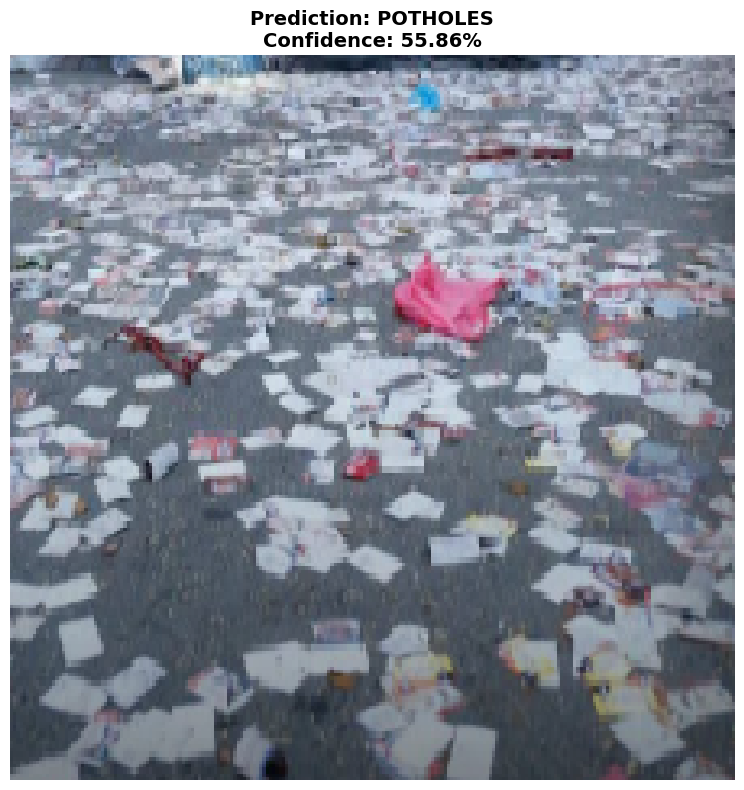

For i1 we got ('Potholes', 0.55856556)


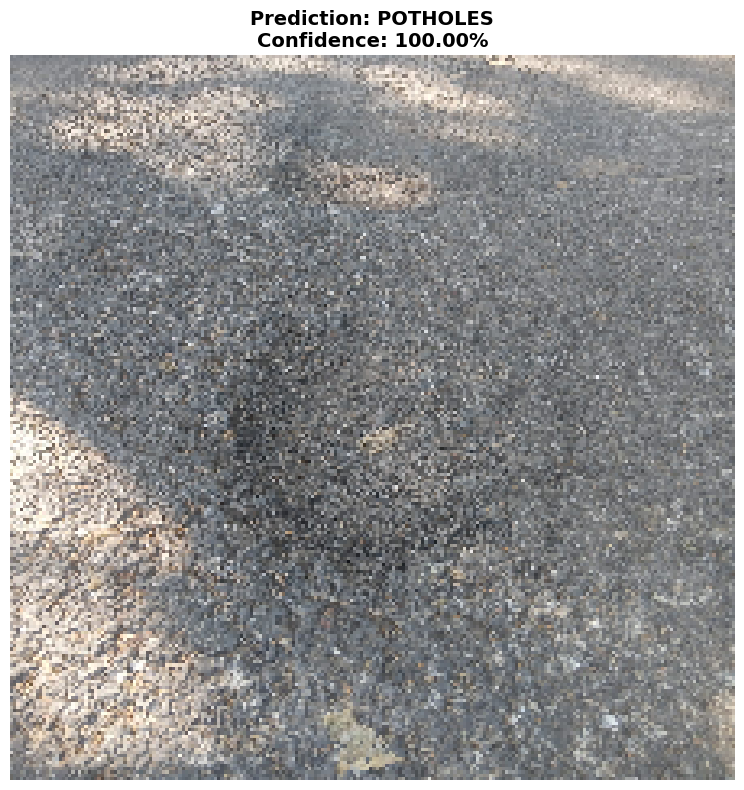

For i11 we got ('Potholes', 0.99999595)


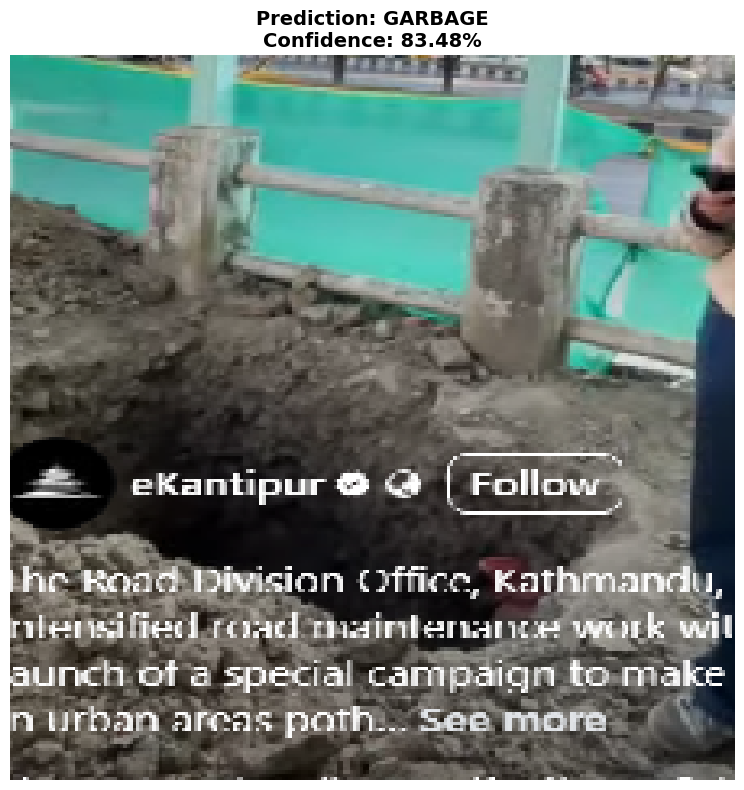

For i2 we got ('Garbage', 0.8347982615232468)


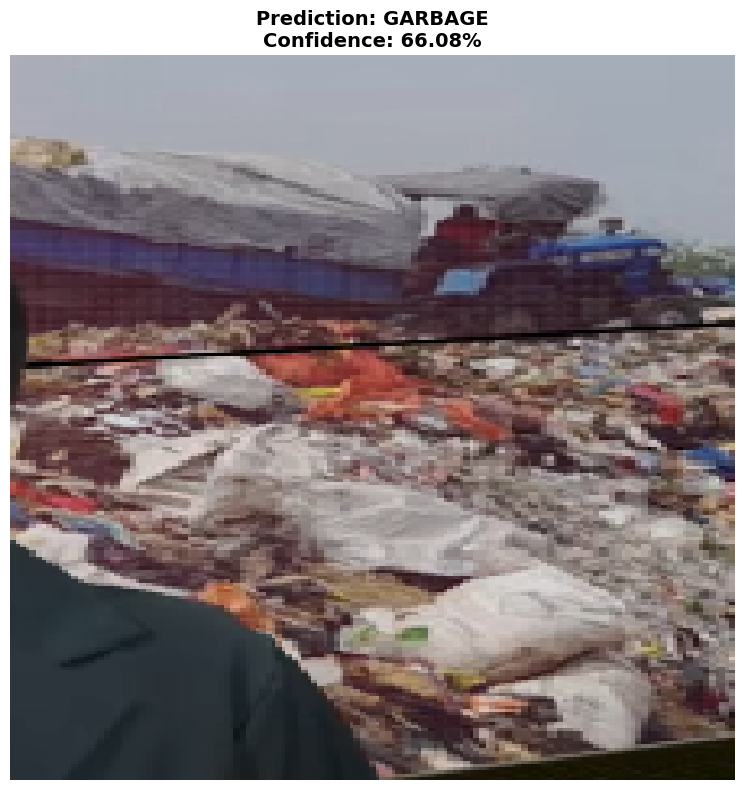

For i3 we got ('Garbage', 0.6607599854469299)


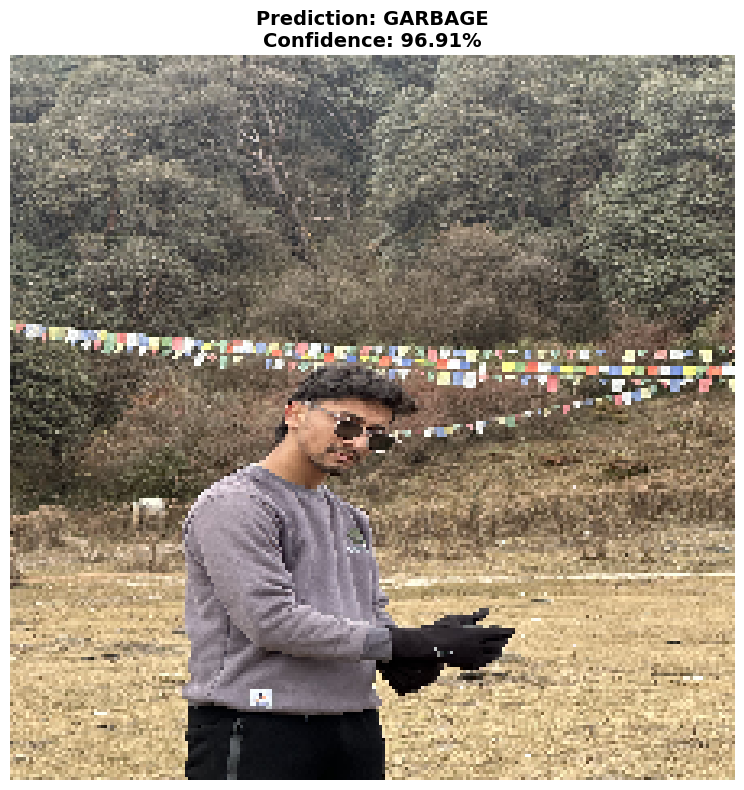

For n1 we got ('Garbage', 0.9691260401159525)


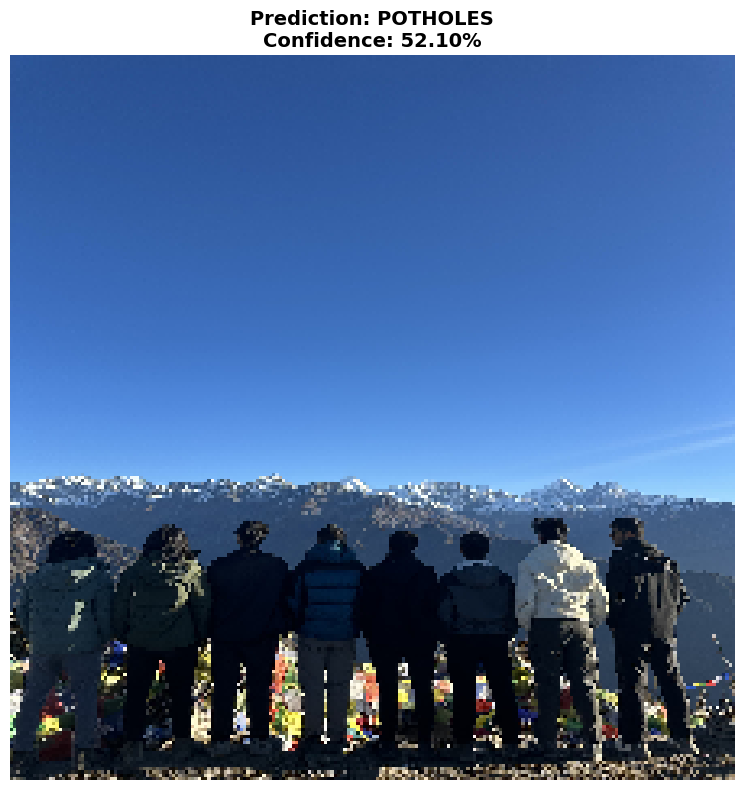

For n2 we got ('Potholes', 0.5209923)


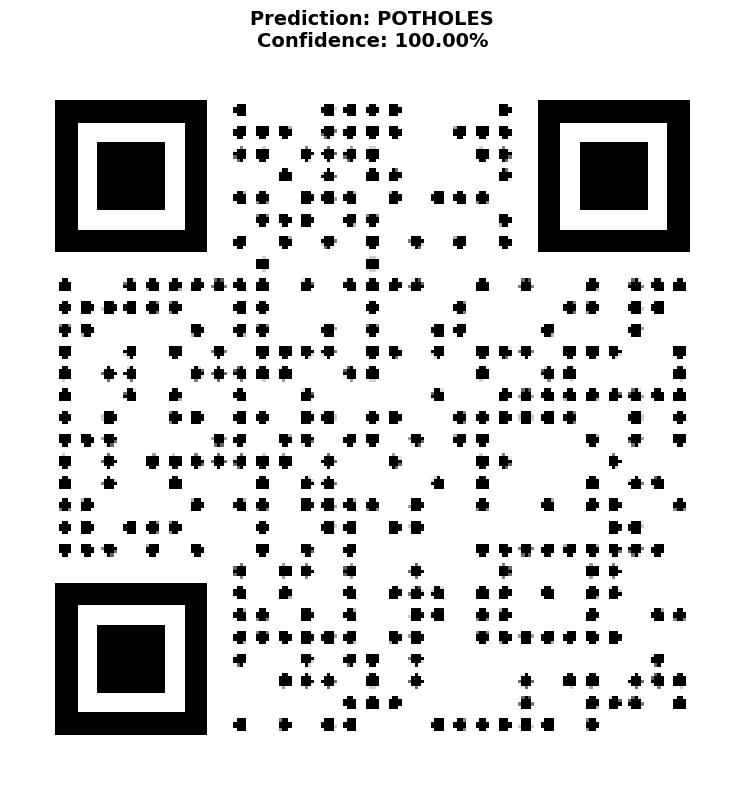

For n3 we got ('Potholes', 0.9999776)


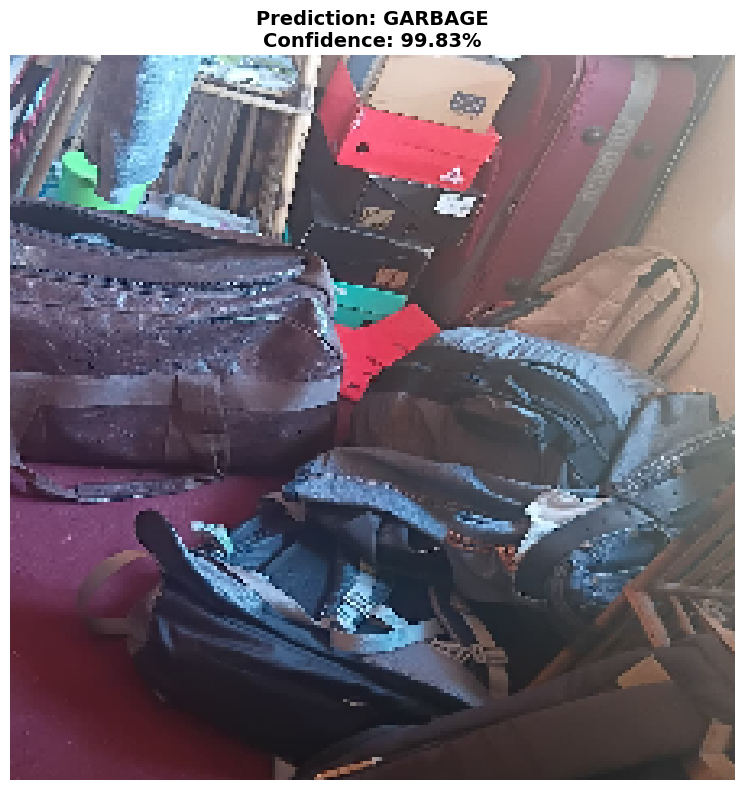

For n4 we got ('Garbage', 0.9982993440935388)


In [36]:
print(f"For i1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i1.png')}")
print(f"For i11 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i11.jpeg')}")
print(f"For i2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i2.png')}")
print(f"For i3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i3.png')}")
print(f"For n1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n1.jpg')}")
print(f"For n2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n2.jpg')}")
print(f"For n3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n3.png')}")
print(f"For n4 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")